In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/prototype')
from keras.layers import Input, Dense
from keras.models import Model
from keras import callbacks
import time, random
import scipy
import seaborn as sns
sns.set(palette='dark', font_scale = 1)
pd.set_option('display.max_columns', None)

In [2]:
np.random.seed(216)
from tensorflow import set_random_seed

sample_data = pd.read_csv('sample_simulated_transaction_history.csv')
sample_data.date = pd.to_datetime(sample_data.date)

In [3]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [4]:
df = sample_data[(sample_data.category == 'Tees & Polos')].reset_index(drop = True)[['id','date', 'purchaseamount']]
df = df.pivot_table(index=['id'], columns='date', values='purchaseamount', aggfunc='mean').fillna(0).T

In [5]:
pre_start_date = '2015-01-01'
pre_end_date = '2015-12-31'

In [6]:
df['dummy_donor_1'] = pd.DataFrame({'dummy_donor_1':df.iloc[:,-1].shift()})
df['dummy_donor_2'] = pd.DataFrame({'dummy_donor_2':df.iloc[:,-2].shift(-1)})
df['dummy_donor_3'] = pd.DataFrame({'dummy_donor_3':df.iloc[:,-3]*1.7})
df = df.fillna(0)

In [7]:
xtrain1 = df[pre_start_date:pre_end_date][df.columns[:5000]].values.T
xtest1 = df[pre_start_date:pre_end_date][df.columns[5000:]].values.T

In [8]:
columns = (xtrain1 == 0).sum(0)
rows = (xtrain1 == 0).sum(1)
print(rows.sum()*100/(xtrain1.shape[0]*xtrain1.shape[1]))

96.51298630136986


In [9]:
columns = (xtest1 == 0).sum(0)
rows = (xtest1 == 0).sum(1)
print(rows.sum()*100/(xtest1.shape[0]*xtest1.shape[1]))

96.52494571081277


In [10]:
DIM = 70

encoding_dim1 = DIM*5
encoding_dim2 = DIM*4
encoding_dim3 = DIM*3
encoding_dim4 = DIM

In [11]:
inputs = Input(shape=(xtrain1.shape[1],))

encoded1 = Dense(encoding_dim1, activation='tanh')(inputs)
encoded2 = Dense(encoding_dim2, activation='tanh')(encoded1)
encoded3 = Dense(encoding_dim3, activation='tanh')(encoded2)
encoded4 = Dense(encoding_dim4, activation='tanh')(encoded3)
decoded1 = Dense(encoding_dim3, activation='tanh')(encoded4)
decoded2 = Dense(encoding_dim2, activation='tanh')(decoded1)
decoded3 = Dense(encoding_dim1, activation='relu')(decoded2)
decoded4 = Dense(xtrain1.shape[1], activation='relu')(decoded3)

autoencoder = Model(inputs, decoded4)
encoder = Model(inputs, encoded4)
hidden_1 = Model(inputs, encoded1)
hidden_2 = Model(inputs, encoded2)
hidden_3 = Model(inputs, encoded3)

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_2 (Dense)              (None, 280)               98280     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               59010     
_________________________________________________________________
dense_4 (Dense)              (None, 70)                14770     
_________________________________________________________________
dense_5 (Dense)              (None, 210)               14910     
_________________________________________________________________
dense_6 (Dense)              (None, 280)               59080     
__________

In [13]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_2 (Dense)              (None, 280)               98280     
_________________________________________________________________
dense_3 (Dense)              (None, 210)               59010     
_________________________________________________________________
dense_4 (Dense)              (None, 70)                14770     
Total params: 300,160
Trainable params: 300,160
Non-trainable params: 0
_________________________________________________________________


In [14]:
set_random_seed(216)
EPOCHS = 1000
BATCH_SIZE = 500
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(xtrain1, xtrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                  callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')], validation_data = (xtest1, xtest1))

Train on 5000 samples, validate on 1003 samples
Epoch 1/1000
5000/5000 [==============================] - 1s 235us/step - loss: 32.4455 - val_loss: 31.7167
Epoch 2/1000
5000/5000 [==============================] - 1s 139us/step - loss: 31.4985 - val_loss: 31.1163
Epoch 3/1000
5000/5000 [==============================] - 1s 135us/step - loss: 30.8451 - val_loss: 30.4907
Epoch 4/1000
5000/5000 [==============================] - 1s 143us/step - loss: 30.1114 - val_loss: 29.7323
Epoch 5/1000
5000/5000 [==============================] - 1s 134us/step - loss: 29.2187 - val_loss: 28.8528
Epoch 6/1000
5000/5000 [==============================] - 1s 158us/step - loss: 28.2378 - val_loss: 27.9603
Epoch 7/1000
5000/5000 [==============================] - 1s 195us/step - loss: 27.2231 - val_loss: 27.0682
Epoch 8/1000
5000/5000 [==============================] - 1s 169us/step - loss: 26.2062 - val_loss: 26.1738
Epoch 9/1000
5000/5000 [==============================] - 1s 171us/step - loss: 25.2011 

5000/5000 [==============================] - 1s 134us/step - loss: 5.4229 - val_loss: 12.2958
Epoch 77/1000
5000/5000 [==============================] - 1s 130us/step - loss: 5.3768 - val_loss: 12.2450
Epoch 78/1000
5000/5000 [==============================] - 1s 130us/step - loss: 5.3202 - val_loss: 12.2128
Epoch 79/1000
5000/5000 [==============================] - 1s 131us/step - loss: 5.2875 - val_loss: 12.2393
Epoch 80/1000
5000/5000 [==============================] - 1s 131us/step - loss: 5.2601 - val_loss: 12.1854
Epoch 81/1000
5000/5000 [==============================] - 1s 130us/step - loss: 5.2268 - val_loss: 12.2525
Epoch 82/1000
5000/5000 [==============================] - 1s 133us/step - loss: 5.1985 - val_loss: 12.2414
Epoch 83/1000
5000/5000 [==============================] - 1s 131us/step - loss: 5.1686 - val_loss: 12.2438
Epoch 84/1000
5000/5000 [==============================] - 1s 132us/step - loss: 5.1481 - val_loss: 12.1740
Epoch 85/1000
5000/5000 [=================

5000/5000 [==============================] - 1s 132us/step - loss: 4.2911 - val_loss: 12.3331
Epoch 152/1000
5000/5000 [==============================] - 1s 135us/step - loss: 4.2841 - val_loss: 12.3331
Epoch 153/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.2867 - val_loss: 12.3639
Epoch 154/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.2780 - val_loss: 12.4069
Epoch 155/1000
5000/5000 [==============================] - 1s 138us/step - loss: 4.2766 - val_loss: 12.3027
Epoch 156/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.2766 - val_loss: 12.3529
Epoch 157/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.2771 - val_loss: 12.3691
Epoch 158/1000
5000/5000 [==============================] - 1s 131us/step - loss: 4.2815 - val_loss: 12.3680
Epoch 159/1000
5000/5000 [==============================] - 1s 130us/step - loss: 4.2809 - val_loss: 12.4073
Epoch 160/1000
5000/5000 [========

5000/5000 [==============================] - 1s 134us/step - loss: 4.1417 - val_loss: 12.1339
Epoch 227/1000
5000/5000 [==============================] - 1s 131us/step - loss: 4.1350 - val_loss: 12.1244
Epoch 228/1000
5000/5000 [==============================] - 1s 128us/step - loss: 4.1340 - val_loss: 12.1201
Epoch 229/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.1314 - val_loss: 12.1396
Epoch 230/1000
5000/5000 [==============================] - 1s 130us/step - loss: 4.1287 - val_loss: 12.1181
Epoch 231/1000
5000/5000 [==============================] - 1s 145us/step - loss: 4.1271 - val_loss: 12.1460
Epoch 232/1000
5000/5000 [==============================] - 1s 139us/step - loss: 4.1284 - val_loss: 12.0776
Epoch 233/1000
5000/5000 [==============================] - 1s 134us/step - loss: 4.1271 - val_loss: 12.0678
Epoch 234/1000
5000/5000 [==============================] - 1s 133us/step - loss: 4.1284 - val_loss: 12.0724
Epoch 235/1000
5000/5000 [========

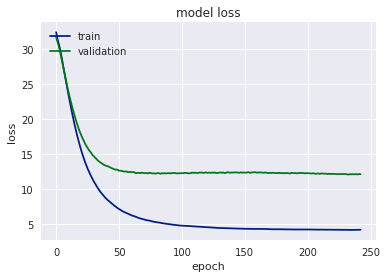

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

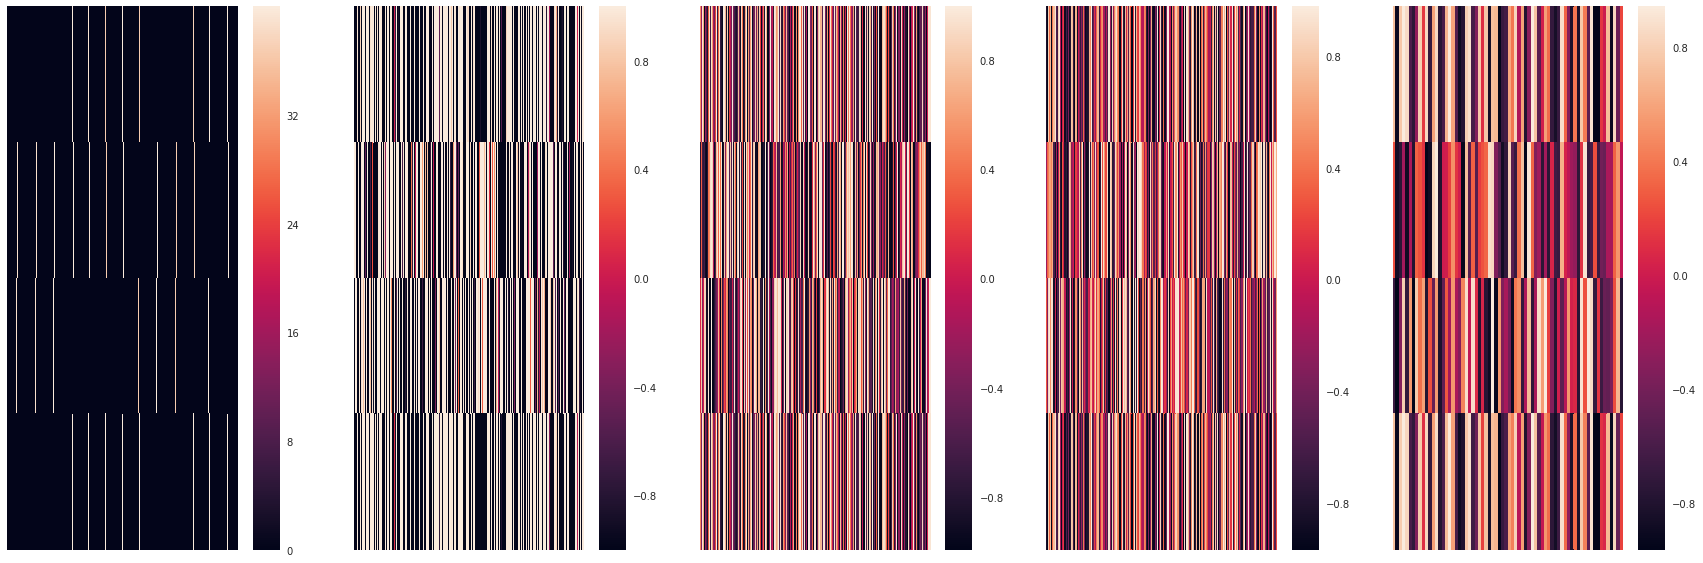

In [16]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True, figsize = (30,10))
sns.heatmap(xtest1[-4:], xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax1)
sns.heatmap(hidden_1.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax2)
sns.heatmap(hidden_2.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax3)
sns.heatmap(hidden_3.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax4)
sns.heatmap(encoder.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax5)
plt.show()

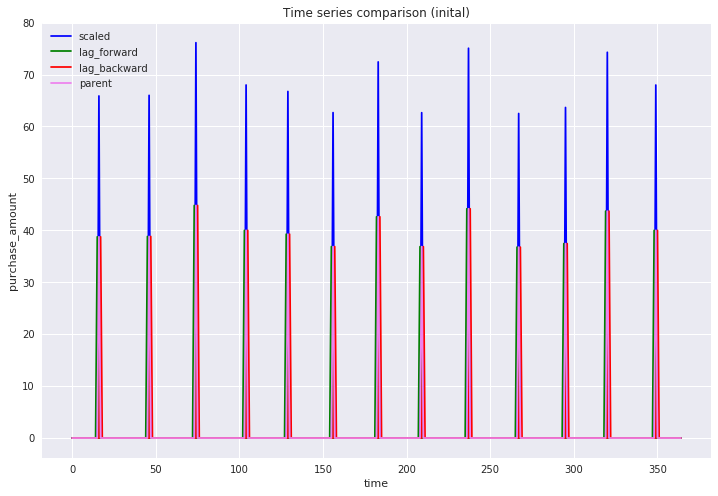

In [17]:
plt.figure(figsize = (12,8))
plt.plot(xtest1[-1], color = 'blue', label = 'scaled')
plt.plot(xtest1[-2], color = 'green', label = 'lag_forward')
plt.plot(xtest1[-3], color = 'red', label = 'lag_backward')
plt.plot(xtest1[-4], color = 'violet', label = 'parent')
plt.title('Time series comparison (inital)')
plt.legend(loc = 'best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [18]:
encoded_mat = encoder.predict(xtrain1)
encoded_mat_test = encoder.predict(xtest1)

decoded_mat = autoencoder.predict(xtrain1)
decoded_mat_test = autoencoder.predict(xtest1)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


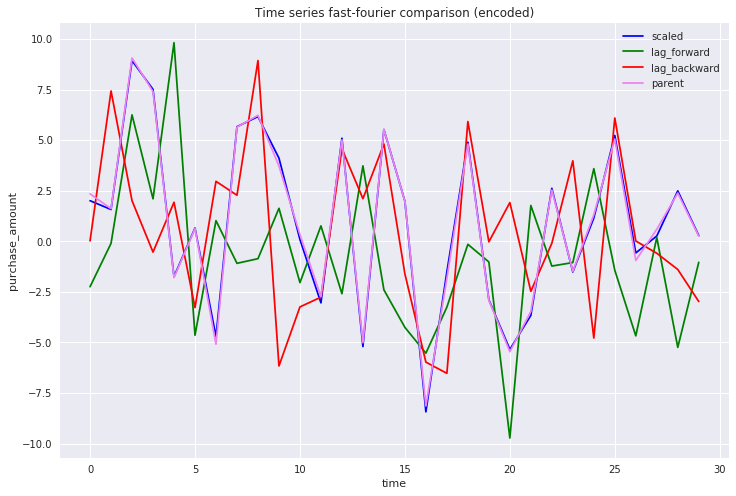

In [19]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(encoded_mat_test[-1])[-30:], color = 'blue', label = 'scaled')
plt.plot(np.fft.fft(encoded_mat_test[-2])[-30:], color = 'green', label = 'lag_forward')
plt.plot(np.fft.fft(encoded_mat_test[-3])[-30:], color = 'red', label = 'lag_backward')
plt.plot(np.fft.fft(encoded_mat_test[-4])[-30:], color = 'violet', label = 'parent')
plt.title('Time series fast-fourier comparison (encoded)')
plt.legend(loc='best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [20]:
encoded_df = pd.DataFrame(encoded_mat)
encoded_df.insert(loc=0, column='id', value=df.columns[:5000].values)
encoded_df = encoded_df.set_index(encoded_df.id).drop(labels = ['id'], axis = 1)
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.773041,0.778460,0.569252,-0.087625,0.744237,-0.974206,0.752783,0.900910,0.854714,0.520311,0.134667,-0.690865,-0.814010,-0.893844,0.256133,0.803318,-0.721184,-0.788063,0.331161,-0.507499,0.568540,0.902390,-0.464479,-0.733965,0.456366,0.573079,-0.893904,0.231876,-0.341636,0.869802,-0.628594,0.743234,-0.741102,-0.453518,0.297697,0.569816,0.853282,0.277266,0.146677,-0.707325,0.868985,0.868900,0.977431,0.028178,-0.949255,0.218321,-0.600811,0.990057,0.917466,0.500918,-0.849252,0.244248,0.672536,-0.694724,-0.745819,-0.771018,0.359041,-0.041717,0.534893,0.485669,0.607755,-0.400118,-0.586702,0.494319,-0.229630,0.883275,-0.903492,0.123512,0.728688,-0.047886
Donor_100,-0.567597,-0.912529,0.229813,-0.923937,0.050721,-0.140363,-0.682248,-0.577686,0.269865,0.830700,0.067037,0.737418,-0.389278,0.860030,-0.307196,-0.952030,-0.398112,-0.370349,-0.582704,-0.406392,-0.653858,-0.935726,0.208960,0.546890,0.721871,-0.425256,-0.963777,0.849117,-0.761924,-0.807588,0.702540,-0.113090,0.657289,-0.386900,0.258306,-0.807357,-0.404723,-0.273608,-0.217589,0.092282,-0.912897,0.263060,0.274315,-0.521279,-0.572418,-0.578381,0.757434,0.778447,0.934066,-0.746770,0.423218,0.920473,0.621484,0.754989,0.169157,-0.796975,0.525600,-0.548298,-0.601509,-0.803720,0.459486,-0.701173,0.966117,0.790600,0.532686,-0.860075,0.643583,0.208823,0.611804,-0.928723
Donor_1000,0.287778,-0.832169,0.611931,-0.708034,0.406125,-0.596024,-0.991942,-0.453294,-0.570684,0.749385,0.945863,-0.188459,0.047005,-0.287481,0.542691,0.708178,-0.063980,-0.370536,0.717629,0.519415,0.793432,-0.892075,-0.216464,-0.246425,0.469688,0.596080,0.294860,0.967812,0.170622,0.345666,0.664356,0.264068,0.438081,0.587117,0.378446,0.128639,-0.210399,-0.148613,-0.434310,-0.397180,-0.710333,0.963013,0.915080,0.731477,0.504675,-0.501001,-0.123401,-0.452514,-0.622534,-0.686644,0.955661,-0.313695,0.549413,0.785134,0.483345,-0.287999,0.396697,-0.241959,0.853536,0.530970,-0.908323,-0.949226,0.421237,-0.915561,0.861111,-0.960512,-0.640351,-0.734725,-0.393373,-0.811082
Donor_1001,0.819213,-0.568655,-0.916404,0.079649,-0.972391,0.606821,0.516329,0.568319,-0.910781,-0.832679,-0.977559,0.497384,-0.598244,0.978266,-0.450347,-0.922036,0.314003,0.026894,0.843561,0.866577,-0.191247,0.513117,0.518003,-0.207887,-0.879988,0.723428,0.801597,0.865216,0.825805,0.810002,0.342304,0.973348,0.111039,-0.537786,-0.661848,-0.539498,0.645263,-0.567847,-0.230064,-0.597794,-0.715512,0.105513,-0.661391,0.728017,-0.679881,-0.630467,0.742269,-0.918431,0.366388,-0.774640,0.547743,0.693032,0.902943,0.905917,-0.222494,0.648759,0.105642,0.851537,0.214582,-0.316927,-0.628701,-0.507886,0.853878,0.807328,-0.470678,-0.727563,-0.836190,0.888351,0.525471,0.100748
Donor_1002,-0.883114,-0.274021,0.912887,0.142543,0.710957,-0.913689,-0.212725,0.296856,0.748744,-0.933880,0.641848,0.351197,-0.827916,-0.659696,-0.699480,-0.005832,-0.065937,0.645857,-0.712305,-0.334862,0.487867,0.244425,0.844409,0.915209,0.596027,-0.679791,-0.329474,0.737817,0.838224,-0.256568,0.677027,-0.987877,-0.005051,-0.832610,0.439877,0.987071,-0.028196,0.211259,0.354661,0.708880,0.900093,-0.212362,-0.909868,-0.806825,0.794240,0.854869,-0.456955,0.770764,-0.930482,-0.830443,-0.812310,-0.054626,-0.533024,0.959394,0.812059,-0.824957,0.823467,0.171337,0.316079,-0.767688,-0.563915,0.687069,-0.871880,-0.753715,0.146838,-0.414660,0.053950,-0.839183,0.799052,-0.337959


In [21]:
encoded_df_test = pd.DataFrame(encoded_mat_test)
encoded_df_test.insert(loc=0, column='id', value=df.columns[5000:].values)
encoded_df_test = encoded_df_test.set_index(encoded_df_test.id).drop(labels = ['id'], axis = 1)
encoded_df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,-0.044888,0.536118,-0.768367,-0.842845,0.601355,0.609171,-0.588871,-0.979628,0.205546,0.380438,-0.677180,0.807642,0.387891,0.239845,-0.783611,0.962521,0.616959,0.812393,-0.070538,0.468924,0.789027,0.658314,-0.574504,0.830641,-0.936926,0.939707,0.906908,-0.533868,0.364888,0.771387,0.638361,-0.639909,0.868743,0.788596,0.456924,0.602685,0.601844,0.497974,0.946985,0.902699,-0.361283,-0.908632,0.827382,-0.765559,0.140895,-0.727871,-0.803170,0.826787,0.939871,-0.136416,-0.985967,0.323048,0.420252,-0.860613,0.370198,-0.725033,-0.716670,0.713189,-0.723239,-0.332861,-0.382394,0.444864,0.108795,0.455627,0.489810,-0.231838,-0.402292,0.481348,-0.895071,-0.323369
Test_145,0.657440,-0.600110,-0.956617,-0.562078,0.751005,0.265461,0.071429,-0.052225,-0.793419,0.856994,-0.969262,-0.688169,0.182959,0.977265,-0.193382,-0.814441,0.091983,0.037656,-0.288680,0.826317,0.510657,-0.460950,0.824823,-0.311251,0.807843,0.412408,0.919690,0.274066,0.894552,0.979782,-0.013802,0.883127,0.349484,-0.254546,-0.881303,0.262646,-0.149553,-0.473105,0.315048,-0.972689,-0.145082,0.748348,0.404364,-0.470343,0.928741,-0.928012,0.736020,-0.721970,0.431345,0.014816,-0.854295,0.048187,-0.884214,0.426417,-0.613424,0.610547,0.934053,0.712944,0.135597,0.547757,-0.772276,-0.853337,0.016108,0.584833,0.375445,-0.388567,-0.587314,0.660460,0.616758,-0.682895
Test_1450,0.207826,-0.920787,-0.737313,0.501615,0.719013,0.872036,-0.645241,0.933227,-0.649067,-0.476235,0.963802,-0.975715,0.741056,-0.599771,0.178447,-0.439360,-0.363464,-0.606751,0.942291,0.567064,-0.543770,0.565599,0.814031,0.565756,-0.750196,0.746673,-0.650795,0.844097,-0.326233,0.293105,0.888296,0.816189,-0.958822,0.943803,0.532151,0.957796,0.842994,-0.503735,-0.556028,0.453690,0.752290,0.823125,-0.846939,0.851337,-0.081711,0.847747,-0.627109,0.508190,-0.982114,0.791845,-0.306215,-0.777829,-0.080654,0.455341,-0.390945,0.803197,-0.802187,-0.366296,0.700293,-0.882995,-0.199818,-0.792177,-0.861013,-0.505484,0.795613,-0.682721,0.672763,-0.145161,-0.827887,0.750811
Test_1451,0.465409,-0.903736,-0.325688,-0.908444,-0.274025,-0.148316,0.748341,-0.835357,-0.022371,-0.818256,0.695425,0.531774,-0.042217,-0.744326,0.523166,0.918419,0.201559,-0.202598,-0.181046,0.943233,0.409855,0.921125,-0.897176,0.849481,-0.335215,-0.061096,-0.426090,0.067117,-0.203738,-0.338258,-0.000875,0.866991,-0.586470,0.430149,0.527276,0.540459,0.622807,0.619558,-0.383128,0.755964,0.285873,-0.852321,-0.792120,-0.371984,-0.641915,-0.440230,0.792088,0.948425,-0.102145,-0.354794,-0.484901,-0.925864,-0.700025,-0.249728,-0.492410,-0.870685,-0.830010,-0.391508,0.546453,-0.226554,0.307177,0.139632,-0.964755,-0.976440,-0.514887,-0.503040,0.909208,-0.505382,-0.821409,0.094120
Test_1452,-0.773093,-0.341255,-0.293424,-0.577355,-0.837313,-0.198300,0.640779,0.910521,-0.853422,0.669956,0.760964,0.932934,-0.846216,-0.248720,-0.308228,-0.844857,0.826923,0.626496,0.729463,0.206260,0.494636,0.234228,-0.445293,-0.471222,-0.592157,0.451711,0.813794,0.563338,0.361503,-0.474335,-0.557033,0.601094,-0.719031,-0.985291,0.040304,-0.989888,-0.454993,0.957025,-0.685521,-0.714436,-0.966476,-0.941404,-0.718851,-0.183976,0.535280,-0.478193,0.965599,-0.851213,-0.018299,-0.644014,-0.504992,-0.170095,-0.658951,0.285764,-0.203305,-0.887205,0.955650,0.478114,-0.897239,-0.231346,0.245363,0.004737,-0.556056,0.103407,-0.779312,-0.026701,-0.733202,0.189953,0.178219,-0.842091


In [22]:
xtrain = pd.DataFrame(xtrain1)
average_initial = xtrain.mean(axis = 0)
xtrain.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
xtrain = xtrain.set_index(xtrain.id).drop(labels = ['id'], axis = 1)
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.0,28.103086,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,25.465567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,29.395883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.681370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,28.54345,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.002926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,27.025801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.822557,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.611507,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.675734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.815237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.406283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.19701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,32.555135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.523447,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.602001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.930828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [23]:
comparison = pd.DataFrame(decoded_mat)
average_decoded = comparison.mean(axis = 0)
comparison.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
comparison = comparison.set_index(comparison.id).drop(labels = ['id'], axis = 1)
comparison.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.0,25.637302,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,28.557198,2.178963,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.95793,0.000000,0.0,0.0,0.583347,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,27.777597,0.0,0.0,0.000000,0.543267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,24.140417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,27.889341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.894655,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,31.89666,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.113462,0.0,0.0,0.0,0.0,0.0,0.0,0.87289,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.316324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.177937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,27.121809,0.0,0.0,0.0,0.0,0.0,0.0,3.949548,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,31.6287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.924002,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,23.704407,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.610012,0.0,0.00000,19.180996,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0

In [24]:
xtest = pd.DataFrame(xtest1)
average_initial_test = xtest.mean(axis = 0)
xtest.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
xtest = xtest.set_index(xtest.id).drop(labels = ['id'], axis = 1)
xtest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,34.0962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,27.922484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,32.689643,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,32.538395,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,31.536311,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,31.296507,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,32.473824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,25.174308,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,27.997594,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,32.697277,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,33.582588,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.953825,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.773184,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.259073
Test_145,0.0,0.0,43.088934,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,43.384996,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,40.449101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.

In [25]:
comparison_test = pd.DataFrame(decoded_mat_test)
average_decoded_test = comparison_test.mean(axis = 0)
comparison_test.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
comparison_test = comparison_test.set_index(comparison_test.id).drop(labels = ['id'], axis = 1)
comparison_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,23.629585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2.729935,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,7.119202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,60.401272,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,72.710869,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,52.682728,0.0,5.66308,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.663761,0.0,14.410479,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.340689,0.0,0.0,0.0,7.040993,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,44.556805,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,13.08475,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,20.570303,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.23502,0.0,0.0,0.000000,12.626499,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,38.859024
Test_145,0.0,7.056593,47.215889,0.0,0.0,0.0,0.0,16.785166,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,6.183683,0.0,0.0,0.0,5.437702,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,13.643199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,52.893852,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,

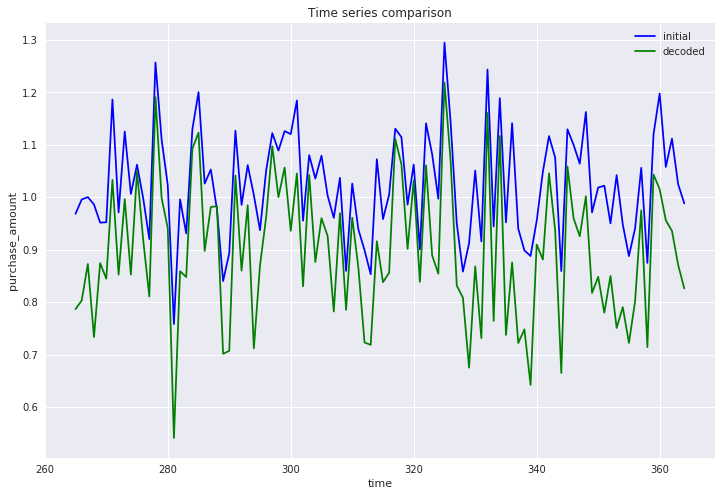

In [26]:
plt.figure(figsize = (12,8))
plt.plot(average_initial[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


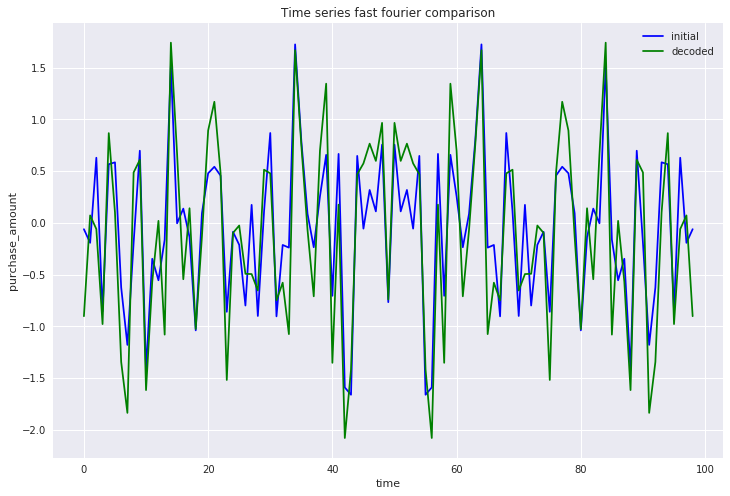

In [27]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

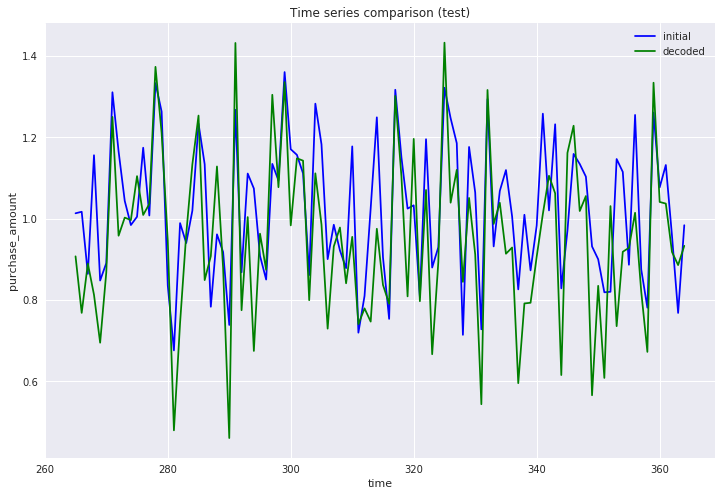

In [28]:
plt.figure(figsize = (12,8))
plt.plot(average_initial_test[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded_test[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


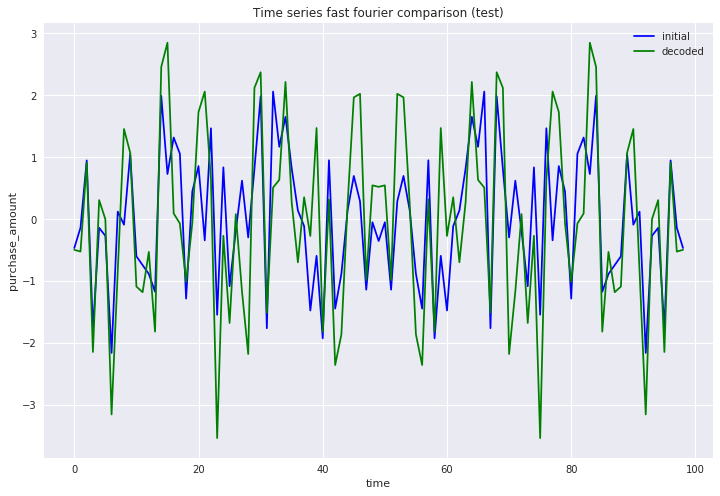

In [29]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial_test[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded_test[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [30]:
binary_xtrain = np.where(xtrain>0, 1, 0)
binary_decoded_mat = np.where(decoded_mat>0,1,0)

binary_xtest = np.where(xtest>0, 1, 0)
binary_decoded_mat_test = np.where(decoded_mat_test>0,1,0)

In [31]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtrain)-np.linalg.norm(decoded_mat))*100/min(np.linalg.norm(xtrain), np.linalg.norm(decoded_mat))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtrain)-np.linalg.norm(binary_decoded_mat))*100/min(np.linalg.norm(binary_xtrain), np.linalg.norm(binary_decoded_mat))))

Percent similarity 93.36119931179628
Percent similarity binary 98.12407277674795


In [32]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtest)-np.linalg.norm(decoded_mat_test))*100/min(np.linalg.norm(xtest), np.linalg.norm(decoded_mat_test))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtest)-np.linalg.norm(binary_decoded_mat_test))*100/min(np.linalg.norm(binary_xtest), np.linalg.norm(binary_decoded_mat_test))))

Percent similarity 96.66640557079972
Percent similarity binary 88.51871302173987


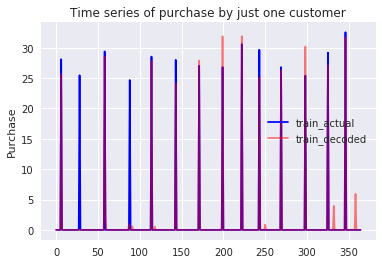

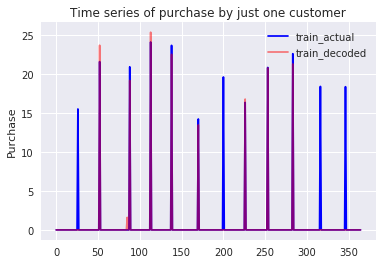

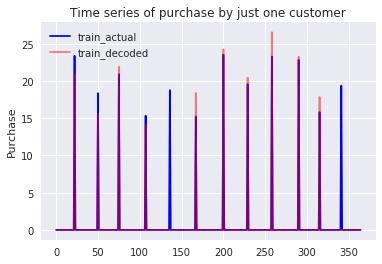

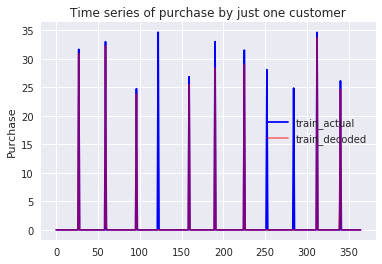

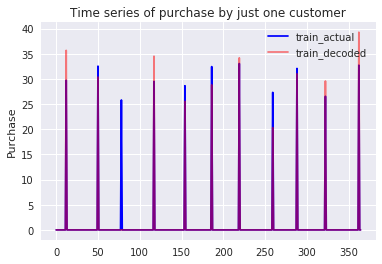

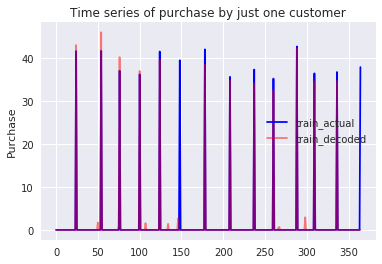

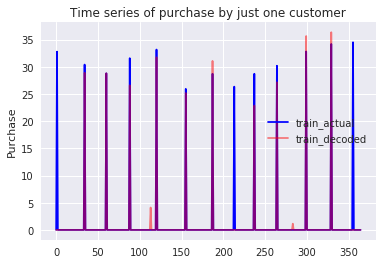

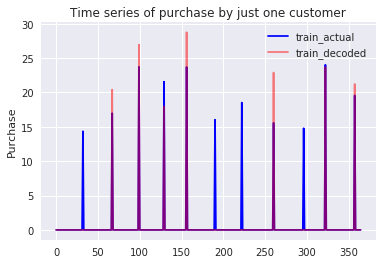

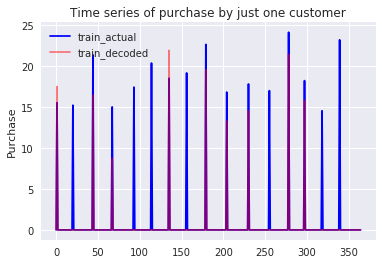

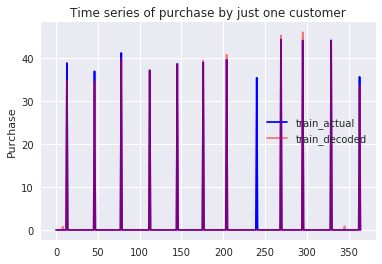

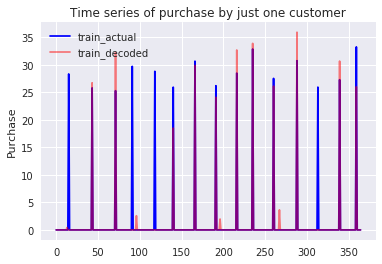

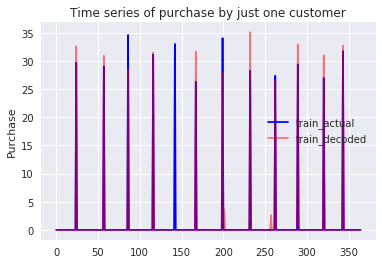

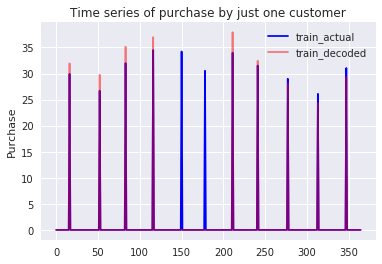

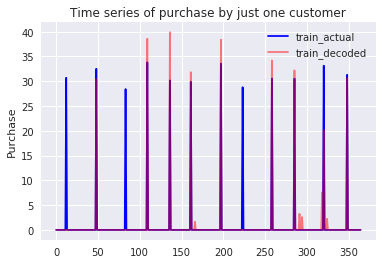

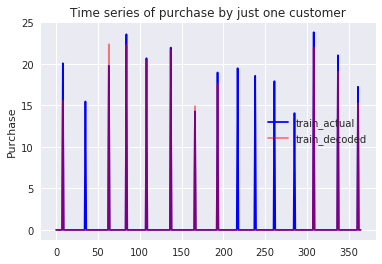

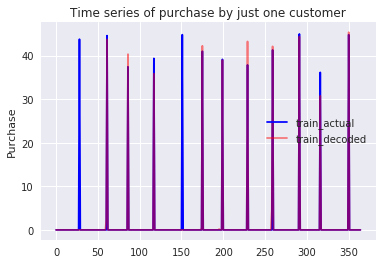

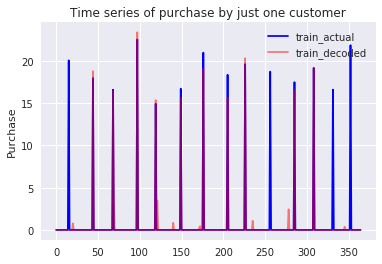

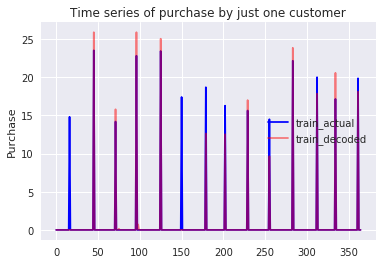

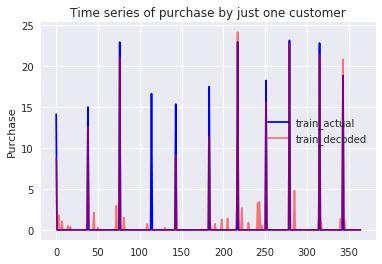

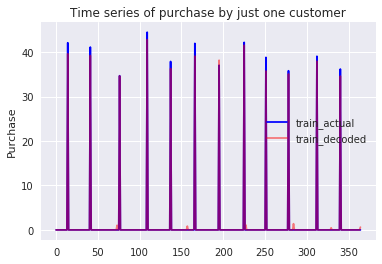

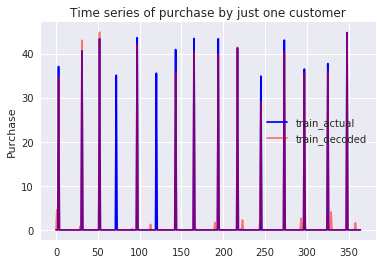

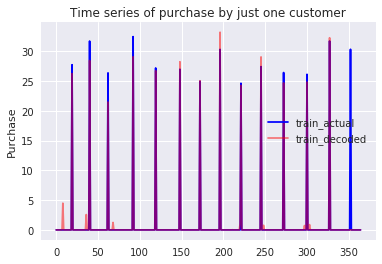

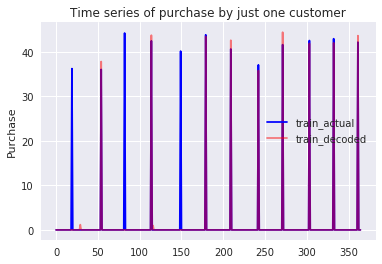

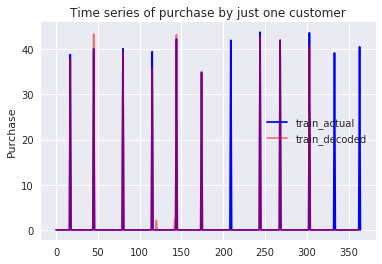

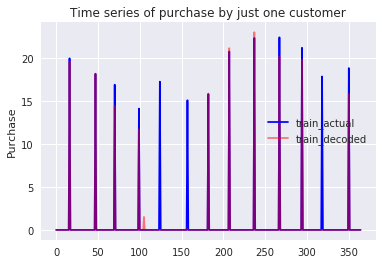

In [33]:
for i in list(xtrain.index[:25]):
    plt.title('Time series of purchase by just one customer')
    plt.plot(xtrain.loc[i,:], color = 'blue', label = 'train_actual')
    plt.plot(comparison.loc[i,:], color = 'red', label = 'train_decoded', alpha=0.5)
    plt.legend(loc='best')
    plt.ylabel('Purchase')
    plt.show()

In [71]:
xtrain_t = xtrain.T

In [ ]:
simulation_start = time.time()
sample_series_1 = pd.DataFrame(xtrain_t['Donor_1'])
sample_series_2 = pd.DataFrame(xtrain_t['Donor_1'])
sample_series_3 = pd.DataFrame(xtrain_t['Donor_1'])
sample_series_4 = pd.DataFrame(xtrain_t['Donor_1'])
sample_series_5 = pd.DataFrame(xtrain_t['Donor_1'])

for j, sample_series in [[.1,sample_series_1], [.2,sample_series_2], [.3,sample_series_3], [.4,sample_series_4], [.5,sample_series_5]]:
    for i in range(30):
        sample_series['lag-%s'%(i+1)] = sample_series.iloc[:,0].shift(i+1).fillna(0)
        sample_series['lag-%s'%(-i-1)] = sample_series.iloc[:,0].shift(-i-1).fillna(0)
        allowable_perturbations = j
        for i in range(len(sample_series.columns)-1):
            for j in range(int(allowable_perturbations/.05)):
                random_number = random.randint(0, int(.95*len(sample_series)))
                sample_series[sample_series.columns[i+1]][random_number:random_number+int(0.05*len(sample_series))] = sample_series[sample_series.columns[i+1]][random_number:random_number+int(0.05*len(sample_series))].shift(random.randint(-7,7)).fillna(0)
                random_number2 = random.randint(0, int(.95*len(sample_series)))
                sample_series[sample_series.columns[i+1]][random_number:random_number+int(0.05*len(sample_series))] = sample_series[sample_series.columns[i+1]][random_number:random_number+int(0.05*len(sample_series))]*np.round(random.uniform(0,2), 2)
                
    for k in range(40):
        random_number3 = random.uniform(0,2)
        sample_series['scale-%s'%np.round(random_number3, 2)] = sample_series.iloc[:,0]*np.round(random_number3, 2)
        allowable_perturbations = j
        for i in range(len(sample_series.columns)-1):
            for j in range(int(allowable_perturbations/.05)):
                random_number = random.randint(0, int(.95*len(sample_series)))
                sample_series[sample_series.columns[i+1]][random_number:random_number+int(0.05*len(sample_series))] = sample_series[sample_series.columns[i+1]][random_number:random_number+int(0.05*len(sample_series))].shift(random.randint(-7,7)).fillna(0)
                random_number2 = random.randint(0, int(.95*len(sample_series)))
                sample_series[sample_series.columns[i+1]][random_number:random_number+int(0.05*len(sample_series))] = sample_series[sample_series.columns[i+1]][random_number:random_number+int(0.05*len(sample_series))]*np.round(random.uniform(0,2), 2)
                
print('Creation time =', time.time()-simulation_start, 'seconds')

In [ ]:
len(sample_series.columns)